In [129]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [130]:
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")
print(model)

{'input': <tf.Variable 'Variable_1:0' shape=(1, 1000, 1000, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu_16:0' shape=(1, 1000, 1000, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_17:0' shape=(1, 1000, 1000, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool_5:0' shape=(1, 500, 500, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_18:0' shape=(1, 500, 500, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_19:0' shape=(1, 500, 500, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_6:0' shape=(1, 250, 250, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_20:0' shape=(1, 250, 250, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_21:0' shape=(1, 250, 250, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_22:0' shape=(1, 250, 250, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_23:0' shape=(1, 250, 250, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_7:0' shape=(1, 125, 125, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_24:0' shape=(1, 125, 125, 512) dtype=float32>, 'conv4_

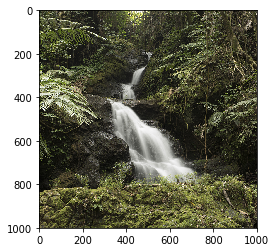

In [131]:
content_image = scipy.misc.imread("images/DSC_1532_1000_1000.jpg")
imshow(content_image)

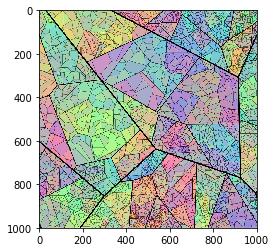

In [132]:
style_image = scipy.misc.imread("images/glass_fractal_1000_1000.jpg")
imshow(style_image)

In [133]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.transpose(tf.reshape(a_C,[-1]))
    a_G_unrolled = tf.transpose(tf.reshape(a_G,[-1]))
    
    # compute the cost with tensorflow (≈1 line)
    J_content = tf.reduce_sum((a_C_unrolled-a_G_unrolled)**2)/(4*n_H*n_W*n_C)
    ### END CODE HERE ###
    
    return J_content

In [134]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    ### START CODE HERE ### (≈1 line)
    GA = tf.matmul(A,tf.transpose(A))
    ### END CODE HERE ###
    
    return GA

In [135]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S = tf.reshape(a_S,[n_H*n_W,n_C])
    a_G = tf.reshape(a_G,[n_H*n_W,n_C])

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(tf.transpose(a_S))
    GG = gram_matrix(tf.transpose(a_G))

    # Computing the loss (≈1 line)
    J_style_layer = tf.reduce_sum((GS-GG)**2)/(4*((n_H*n_W)**2)*(n_C**2))
    
    ### END CODE HERE ###
    
    return J_style_layer

In [136]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [137]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

In [138]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    ### START CODE HERE ### (≈1 line)
    J = alpha*J_content + beta*J_style
    ### END CODE HERE ###
    
    return J

In [158]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

In [159]:
content_image = scipy.misc.imread("images/boston_skyline.jpg")
content_image = reshape_and_normalize_image(content_image)
print(content_image.shape)
#imshow(content_image)
style_image = scipy.misc.imread("images/glass_fractal_1000_1000.jpg")
style_image = reshape_and_normalize_image(style_image)
print(style_image.shape)
#imshow(style_image)

(1, 1000, 1000, 3)
(1, 1000, 1000, 3)


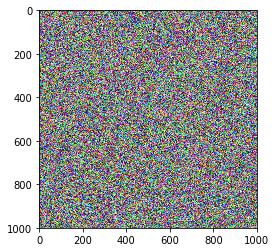

In [160]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [161]:
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")

In [162]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

In [163]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [164]:
### START CODE HERE ### (1 line)
J = total_cost(J_content, J_style, alpha = 10, beta = 40)
### END CODE HERE ###

In [165]:
# define optimizer (1 line)
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step (1 line)
train_step = optimizer.minimize(J)

In [166]:
def model_nn(sess, input_image, num_iterations = 200):
    
    # Initialize global variables (you need to run the session on the initializer)
    ### START CODE HERE ### (1 line)
    sess.run(tf.global_variables_initializer())
    ### END CODE HERE ###
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    ### START CODE HERE ### (1 line)
    sess.run(model['input'].assign(input_image))
    ### END CODE HERE ###
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        ### START CODE HERE ### (1 line)
        _ = sess.run(train_step)
        ### END CODE HERE ###
        
        # Compute the generated image by running the session on the current model['input']
        ### START CODE HERE ### (1 line)
        generated_image = sess.run(model['input'])
        ### END CODE HERE ###

        # Print every 20 iteration.
        if i%1 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output_boston_skyline/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [167]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 2.13892e+10
content cost = 6864.25
style cost = 5.34729e+08
Iteration 1 :
total cost = 2.04599e+10
content cost = 7490.27
style cost = 5.11495e+08
Iteration 2 :
total cost = 1.94911e+10
content cost = 8136.19
style cost = 4.87277e+08
Iteration 3 :
total cost = 1.84993e+10
content cost = 8758.63
style cost = 4.6248e+08
Iteration 4 :
total cost = 1.74706e+10
content cost = 9384.98
style cost = 4.36763e+08
Iteration 5 :
total cost = 1.64128e+10
content cost = 10033.3
style cost = 4.10317e+08
Iteration 6 :
total cost = 1.53387e+10
content cost = 10717.1
style cost = 3.83465e+08
Iteration 7 :
total cost = 1.42642e+10
content cost = 11445.9
style cost = 3.56602e+08
Iteration 8 :
total cost = 1.32092e+10
content cost = 12223.8
style cost = 3.30227e+08
Iteration 9 :
total cost = 1.21973e+10
content cost = 13049.3
style cost = 3.04929e+08
Iteration 10 :
total cost = 1.12526e+10
content cost = 13913.0
style cost = 2.81311e+08
Iteration 11 :
total cost = 1.03956e+10
con

Iteration 94 :
total cost = 5.20288e+08
content cost = 22370.4
style cost = 1.30016e+07
Iteration 95 :
total cost = 5.10786e+08
content cost = 22387.0
style cost = 1.27641e+07
Iteration 96 :
total cost = 5.01598e+08
content cost = 22403.1
style cost = 1.25343e+07
Iteration 97 :
total cost = 4.9271e+08
content cost = 22418.7
style cost = 1.23122e+07
Iteration 98 :
total cost = 4.84105e+08
content cost = 22433.9
style cost = 1.2097e+07
Iteration 99 :
total cost = 4.75774e+08
content cost = 22448.7
style cost = 1.18887e+07
Iteration 100 :
total cost = 4.67704e+08
content cost = 22463.2
style cost = 1.1687e+07
Iteration 101 :
total cost = 4.59887e+08
content cost = 22477.3
style cost = 1.14916e+07
Iteration 102 :
total cost = 4.52314e+08
content cost = 22491.2
style cost = 1.13022e+07
Iteration 103 :
total cost = 4.44973e+08
content cost = 22504.9
style cost = 1.11187e+07
Iteration 104 :
total cost = 4.37853e+08
content cost = 22518.2
style cost = 1.09407e+07
Iteration 105 :
total cost = 4

Iteration 187 :
total cost = 1.86635e+08
content cost = 23062.4
style cost = 4.6601e+06
Iteration 188 :
total cost = 1.85298e+08
content cost = 23066.9
style cost = 4.62668e+06
Iteration 189 :
total cost = 1.83977e+08
content cost = 23071.4
style cost = 4.59366e+06
Iteration 190 :
total cost = 1.82673e+08
content cost = 23076.1
style cost = 4.56104e+06
Iteration 191 :
total cost = 1.81383e+08
content cost = 23080.7
style cost = 4.52881e+06
Iteration 192 :
total cost = 1.80109e+08
content cost = 23085.4
style cost = 4.49695e+06
Iteration 193 :
total cost = 1.78849e+08
content cost = 23090.1
style cost = 4.46546e+06
Iteration 194 :
total cost = 1.77605e+08
content cost = 23094.7
style cost = 4.43435e+06
Iteration 195 :
total cost = 1.76376e+08
content cost = 23099.4
style cost = 4.40363e+06
Iteration 196 :
total cost = 1.75162e+08
content cost = 23104.1
style cost = 4.37326e+06
Iteration 197 :
total cost = 1.73961e+08
content cost = 23108.7
style cost = 4.34325e+06
Iteration 198 :
total 

FileNotFoundError: [Errno 2] No such file or directory: 'output/generated_image.jpg'